In [1]:
#Необходимо установить Neo4j Desktop, APOC в Neo4j
#Устанавливаем модуль 'pip install git+https://github.com/ybaktir/networkx-neo4j' от Yusuf Baktir, Ph.D.
#Yusuf Baktir, для динамической визуализации на основе vis и использования алгоритмов GDS

from neo4j import GraphDatabase
import pandas as pd
import py2neo as p2n
import requests, yadisk, sys, os, zipfile, neo4jupyter
import networkx as nx
import nxneo4j as ne
import numpy as np
import requests

import community
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib.parse import urlencode
from graphdatascience import GraphDataScience

In [2]:
#Исходные данные 
#путь к папке хранения файлов импорта базы neo4j - нужно скопировать свой
#читаем как подключиться к API Яндекс.Диска тут: https://yandex.ru/dev/id/doc/ru/concepts/ya-oauth-intro
path_file = os.path.join(os.environ['HOMEDRIVE'], os.environ['HOMEPATH'], '.Neo4jDesktop', 'relate-data', 'dbmss', 'dbms-b73ce0db-e413-482f-932e-8e24c4f910a8', 'import')

#Яндекс.Диск данные для получения доступа
id_ya = '____________________________' #<id-приложения>
sec_ya = '____________________________'#<secret-приложения>

b_host = 'bolt://localhost:7687'
host = 'http://localhost:7474/db/data/'
user = 'neo4j'
password= 'neo4jneo4j'

#gds = GraphDataScience(host, auth=(user, password))
graph = p2n.Graph(b_host, auth=(user, password))
driver = GraphDatabase.driver(uri=b_host, auth=(user, password))

In [ ]:
#Распределение узлов графа по категориями в рамках сообществ, используя функцию ранжирования pagerank

def categorize(G, part, func):
    distrib = {"Лидеры": 0.05, "Посредники": 0.2}
    result = {node: 1 for node in G.nodes()}
    
    # Идем по всем сообществам
    for p in range(max(part.values())+1):
        print('{:^60}'.format("Сообщество " + str(p+1)))
        
        # Выделяем всех членов этого сообщества
        members = [key for key, val in part.items() if val == p]
        # Выделяем подграф соответсвующий этим членам
        sub_graph = nx.DiGraph(G).subgraph(members)
        # Вычисляем Page Rank
        pagerank = func(sub_graph)
        pagerank = sorted(pagerank.items(), key=lambda x: x[1])
        pagerank = [item[0] for item in pagerank]
        # Распределяем по категориям
        old = [0]
        for t, d in distrib.items():
            count = round(len(members)*d)
            selected_members = pagerank[old[-1]:count]
            old.append(count)
            print("{:11}: {}".format(t, selected_members))
            for member in selected_members:
                result[member] = len(old)
        print()  
    return result

In [ ]:
#Аутентификация на Яндекс.Диске
y = yadisk.YaDisk(id_ya, sec_ya)
url = y.get_code_url()

print("Переходим по ссылке для получения кода: %s" % url)
code = input("Введите код: ")

try:
    response = y.get_token(code)
except yadisk.exceptions.BadRequestError:
    print("Неверный код!")
    sys.exit(1)

y.token = response.access_token

if y.check_token():
    print("Успешно!")
else:
    print("Неудачно!")

In [ ]:
#Загрузка файла
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/s6wWqd8Ol_5IvQ'  # Ссылка на данные

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
headers = {"Authorization": f"OAuth {y.token}"}
response = requests.get(final_url, headers=headers)
download_url = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
print('Скачали архив с данными и распаковали в папку:')

with open('GraphTask.zip', 'wb') as f:
    f.write(download_response.content)
with zipfile.ZipFile('GraphTask.zip','r') as zip_ref:
    zip_ref.extractall(path_file)
print(path_file)

In [133]:
#Загрузка данных в базу Neo4j через py2neo

graph.delete_all()
query_in = '''
LOAD CSV WITH HEADERS FROM 'file:///GraphTask/data_test.csv' AS line FIELDTERMINATOR ';'
CREATE (p1:participant_1 {FullName:line.`ФИО участника события 1`})-[:PARTICIPATION_IN]->(:event {id_event:line.`id события`})<-[:PARTICIPATION_IN]-(p2:participant_2 {FullName:line.`ФИО участника события 2`}) 
'''
graph.run(query_in).data()

[]

In [18]:
# Выгрузка и подготовка данных для анализа графа, очистка от шума
query_out = '''
MATCH (source)-[part_in:PARTICIPATION_IN]->(dest:event)
WITH COLLECT(source)+COLLECT(dest) AS myNodes
UNWIND myNodes as myNode
MATCH p=(myNode)-[:PARTICIPATION_IN]->(neighbor)
RETURN  myNode.`FullName` as child, neighbor.`id_event` as parent // LIMIT 20
'''

df = pd.DataFrame(graph.run(query_out).data())

df1=pd.pivot_table(df,  index = ['child'],
                    aggfunc='count').reset_index().sort_values(by=['parent'])
df1 = df1[df1['parent'] > 1]

df2=pd.pivot_table(df,  index = ['parent'],
                    aggfunc='count').reset_index().sort_values(by=['child'])
df2 = df2[df2['child'] > 2]

df1 = df[df['child'].isin(df1['child'])]
df2 = df[df['parent'].isin(df2['parent'])]
df3 = pd.concat([df1,df2], axis=0)
print('Получим датафрейм участников множеств событий(>1) и событий, в которых участвовали множества участников(>2):')
display(df3)

Получим датафрейм участников множеств событий(>1) и событий, в которых участвовали множества участников(>2):


,child,parent
2,Бугайчук Роман Эдуардович,972769
3,Анихнова Тамара Руслановна,972769
697,Ахромеева Алина Ивановна,42389
805,Ахромеева Алина Ивановна,53707
871,Ахромеева Алина Ивановна,59801
...,...,...
8979,Старовойтов Вячеслав Павлович,873359
9628,Хрисогонов Иван Геннадьевич,938764
9629,Солтаганов Федор Ефимович,938764
9630,Двигубская Яна Ивановна,938764


In [103]:
#Визулизируем граф и ищем взаимосвязи

config ={
'node_label': 'Node',
'relationship_type': 'PARTICIPATION_IN',
'identifier_property': 'id'
}

Gnx = nx.DiGraph()
Gne = ne.DiGraph(driver, config=config)
Gne.delete_all()
Gnx.clear()
tuples = [tuple(x) for x in df3.values]
Gnx.add_edges_from(tuples)
Gne.add_edges_from(tuples)
partition = community.best_partition(Gnx.to_undirected())

##Для корректного отображения кириллицы требуется сменить кодировку в EnvironmentFolder/Lib/site-packages/nxneo4j/draw.py, т.е. 
#в заголовке html-кода формирования страницы vis.html (ln 33, col 5) переменную charset поменять с =utf8 на =windows-1251

ne.draw(Gne, limit=400)

In [123]:
if nx.is_directed(Gnx):
    if nx.is_weakly_connected(Gnx):
        print('Граф является направленным и состоит из одной компоненты слабой связности.')
    else:
        print('Граф является направленным и состоит из нескольких компонент.')
else:
    if nx.is_connected(Gnx):
        print('Граф является ненаправленным и связным.')
    else:
        print('Граф является ненаправленным и состоит из {} компонент, с числом элементов {}'.format(len([len(c) for c in sorted(nx.connected_components(Gnx), key=len, reverse=True)]), [len(c) for c in sorted(nx.connected_components(Gnx), key=len, reverse=True)]))
print('Количество вершин: {}'.format(Gnx.number_of_nodes()))
print('Количество рёбер: {}'.format(Gnx.number_of_edges()))
print('Среднее количество соседей у узлов в графе: {}'.format(round(Gnx.number_of_edges() / float(Gnx.number_of_nodes()), 4)))

Граф является направленным и состоит из нескольких компонент.
Количество вершин: 203
Количество рёбер: 187
Среднее количество соседей у узлов в графе: 0.9212


In [124]:
#Используем функцию для определения сообществ
category = [categorize(Gnx, partition, nx.pagerank)]

                        Сообщество 1                        
Лидеры     : ['Ахромеева Алина Ивановна', '225320']
Посредники : ['348605', '771971', '61824', '800116', '89429', '731215', '879195', '859854']

                        Сообщество 2                        
Лидеры     : []
Посредники : ['Стрик Элина Марселевна']



In [114]:
#Также делим граф на подграфы по степени связности
G_weak = Gnx.subgraph(max(nx.weakly_connected_components(Gnx), key=len))
print('Количество вершин в компоненте слабой связности: {}'.format(G_weak.number_of_nodes()))
print('Количество рёбер в компоненте слабой связности: {}'.format(G_weak.number_of_edges()))
print('Среднее количество соседей у узла в компоненте слабой связности: {}\n'.format(round(G_weak.number_of_edges() / float(G_weak.number_of_nodes()), 4)))

G_strong = Gnx.subgraph(max(nx.strongly_connected_components(Gnx), key=len))
print('Количество вершин в компоненте сильной связности: {}'.format(G_strong.number_of_nodes()))
print('Количество рёбер в компоненте сильной связности: {}'.format(G_strong.number_of_edges()))
print('Среднее количество соседей у узла в компоненте сильной связности: {}'.format(round(G_strong.number_of_edges() / float(G_strong.number_of_nodes()), 4)))

Количество вершин в компоненте слабой связности: 54
Количество рёбер в компоненте слабой связности: 53
Среднее количество соседей у узла в компоненте слабой связности: 0.9815

Количество вершин в компоненте сильной связности: 1
Количество рёбер в компоненте сильной связности: 0
Среднее количество соседей у узла в компоненте сильной связности: 0.0


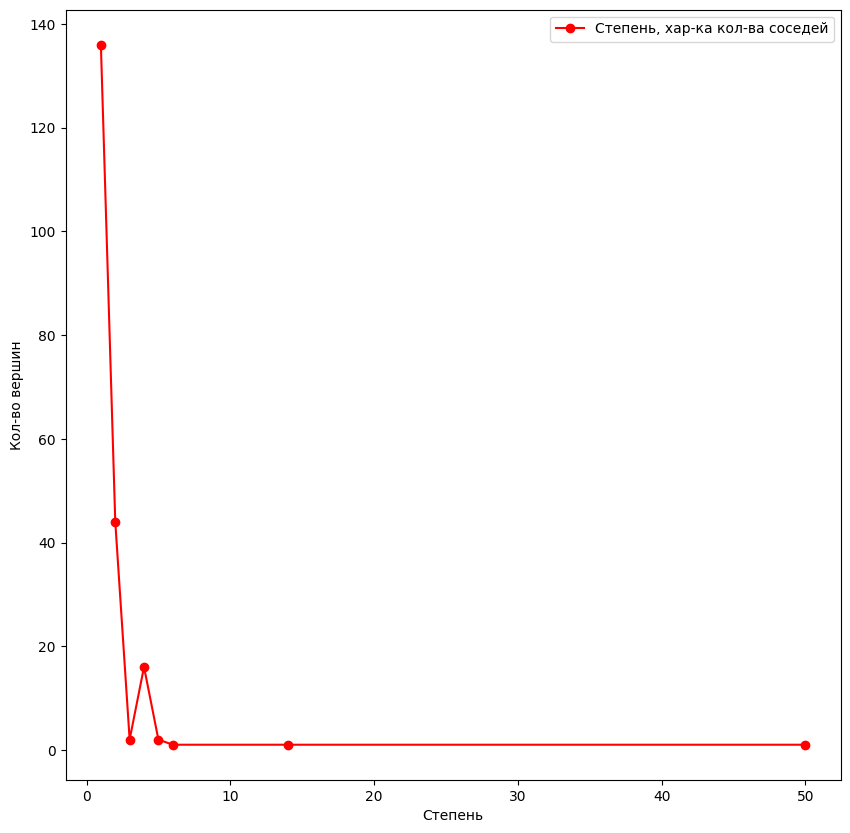

In [115]:
#Строим график зависимости количества связей и количества вершин - график степеней вершин графа
degree = dict(Gnx.degree())
degree_values = sorted(set(degree.values()))
hist = [list(degree.values()).count(x) for x in degree_values]
plt.figure(figsize=(10, 10))
plt.plot(degree_values, hist, 'ro-')
plt.legend(['Степень, хар-ка кол-ва соседей'])
plt.xlabel('Степень')
plt.ylabel('Кол-во вершин')
plt.show()

In [129]:
G_undirected = G_weak.to_undirected()
partition = community.best_partition(G_undirected)
communities = set(partition.values())
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}
highest_degree = {k: sorted(v, key=lambda x: Gnx.degree(x))[-5:] for k, v in communities_dict.items()}
print('Количество сообществ: ', len(highest_degree))
print('Количество элементов в выделенных сообществах:', ', '.join([str(len(highest_degree[key])) for key in highest_degree]))
print('Элементы в выделенных сообществах:', ', '.join([str(highest_degree[key]) for key in highest_degree]))

Количество сообществ:  2
Количество элементов в выделенных сообществах: 5, 4
Элементы в выделенных сообществах: ['632506', '322516', '752080', '638471', 'Ахромеева Алина Ивановна'], ['Борчин Павел Робертович', 'Ларищев Илья Александрович', 'Стрик Элина Марселевна', '850472']


In [122]:
print ('Уровень взаимности графа: ', nx.overall_reciprocity(Gnx))
print ('Уровень взаимности компоненты слабой связности: ', nx.overall_reciprocity(G_weak))
#print ('Уровень взаимности компоненты сильной связности: ', nx.overall_reciprocity(G_strong))

Уровень взаимности графа:  0.0
Уровень взаимности компоненты слабой связности:  0.0


***Вывод: в исходных данных в основном присуствуют связи единичных пар участников и единичных событий, которые не представляют интересса для исследования, т.к. не формируют взаимосвязей с иными участниками и событиями. Принимаем такие связи за шум, выделяем события, в которых участвовали несколько пар участников, а также участников, которые участвовали в нескольких событиях, формируем их этих элементов граф, вершины которого - это участники и события, рёбра - направленные связи между событиями и участниками. В итоге, получаем направленный граф, состоящий из нескольких компонент, в основном слабой связности, в которых опреляются 2 сообщества. По графику степеней вершин графа видим, что большинство вершин графа почти не имеют соседей и имеет крайне низкое разнообразие степеней представленных в графе вершин, взаимность в графе отсуствует.***

In [34]:
#REST сервис выгрузки json из графовой БД по ФИО
f_name = input("Введите ФИО (например, 'Галчевская Карина Владимировна'): ")
#f_name = 'Галчевская Карина Владимировна'
payload = {
  "statements": [
    {
      "statement": "MATCH (n) WHERE (n.FullName) = $f_name RETURN n",
      "parameters": {
        "f_name": f_name
      }
    }
  ]
}

res = requests.post('http://localhost:7474/db/neo4j/tx/commit', json=payload)
if 'meta' in res.text:
    print('Найдено, ответ в json: {}'.format(res.text))
else:
    print('ФИО не найдено!')

Введите ФИО (например, 'Галчевская Карина Владимировна'): Галчевская Карина Владимировна
Найдено, ответ в json: {"results":[{"columns":["n"],"data":[{"row":[{"FullName":"Галчевская Карина Владимировна"}],"meta":[{"id":0,"elementId":"4:e572e579-2743-47af-9d0c-cd28a5b14304:0","type":"node","deleted":false}]}]}],"errors":[]}
